In [112]:
!pip install emoji

In [113]:
!pip install wordcloud

In [114]:
import regex
import pandas as pd
import numpy as np
import emoji
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [115]:
import regex

def limpiar_espacios(s):
    # Reemplaza espacios especiales por espacios normales
    return s.replace('\u202f', ' ').replace('\xa0', ' ').replace('\u200e', '')

def date_time(s):
    s = limpiar_espacios(s)
    # Acepta formatos 1/4/2024, 8:05 p. m. -   o  1/4/2024, 8:05 AM -
    patron = r'^\d{1,2}/\d{1,2}/\d{4}, \d{1,2}:\d{2}(?:\s?(?:AM|PM|am|pm|a\. m\.|p\. m\.))? -'
    return bool(regex.match(patron, s))

def getDatapoint(line):
    line = limpiar_espacios(line)
    # Extraer fecha, hora y mensaje
    m = regex.match(
        r'^(?P<date>\d{1,2}/\d{1,2}/\d{4}), (?P<time>\d{1,2}:\d{2}(?:\s?(?:AM|PM|am|pm|a\. m\.|p\. m\.))?) - (?P<msg>.*)$',
        line
    )
    if not m:
        return None, None, None, line

    date = m['date']
    time = m['time']
    msg = m['msg']

    # Separar autor y mensaje
    m2 = regex.match(r'^(?P<author>[^:]+):\s(?P<message>.*)$', msg)
    if m2:
        return date, time, m2['author'], m2['message']
    else:
        return date, time, None, msg


In [116]:
data = []
conversation = 'Chat de WhatsApp con Unidos por Cristo.txt'

with open(conversation, encoding="utf-8") as fp:
    fp.readline()  # saltar línea inicial
    messageBuffer = []
    date = time = author = None

    for raw in fp:
        line = raw.strip()
        if date_time(line):
            if messageBuffer:
                data.append([date, time, author, ' '.join(messageBuffer)])
                messageBuffer.clear()
            date, time, author, message = getDatapoint(line)
            messageBuffer.append(message)
        else:
            messageBuffer.append(line)

    if messageBuffer:
        data.append([date, time, author, ' '.join(messageBuffer)])


In [117]:
# Crear DataFrame
df = pd.DataFrame(data, columns=["Date", "Time", "Author", "Message"])

# Normalizar a.m./p.m.
df['Time'] = df['Time'].str.replace(r'a\. m\.', 'am', regex=True)
df['Time'] = df['Time'].str.replace(r'p\. m\.', 'pm', regex=True)

# Convertir Date a formato YYYY-MM-DD
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce').dt.strftime('%Y-%m-%d')

# Asegurar que Time esté en minúsculas y sin espacios extra
df['Time'] = df['Time'].str.strip().str.lower()

# Mostrar últimas filas
df.tail(10)

,Date,Time,Author,Message
5312,2025-06-20,9:03 pm,Luz Flores principe De Paz,Jejeje
5313,2025-06-20,9:03 pm,Luz Flores principe De Paz,Lo bueno que ya está el Rodrigo
5314,2025-06-20,9:03 pm,Luz Flores principe De Paz,Que nos hace el suplemento
5315,2025-06-20,9:35 pm,VICTOR Principe De Paz,👍🏽👍🏽👍🏽
5316,2025-06-21,11:41 am,Luz Flores principe De Paz,<Multimedia omitido>
5317,2025-06-21,11:46 am,Alex Príncipe De Paz,<Multimedia omitido>
5318,2025-06-21,1:29 pm,VICTOR Principe De Paz,<Multimedia omitido>
5319,2025-06-21,1:30 pm,Luz Flores principe De Paz,<Multimedia omitido>
5320,2025-06-21,1:31 pm,Alex Príncipe De Paz,Jaja ya parezco doñita
5321,2025-06-21,2:03 pm,Luz Flores principe De Paz,<Multimedia omitido>


In [118]:
def limpiar_espacios(s):
    return s.replace('\u202f', ' ').replace('\xa0', ' ').strip()
    
def split_count(text):
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.EMOJI_DATA for char in word):  # nueva forma
            emoji_list.append(word)
    return emoji_list

df['emoji'] = df["Message"].apply(split_count)
total_messages = df.shape[0]
emojis = df['emoji'].str.len().sum()
# Contar mensajes de tipo multimedia
media_messages = df["Message"].apply(limpiar_espacios).str.lower().eq("<multimedia omitido>").sum()

In [119]:
print(f"Total de mensajes al grupo: {total_messages}")
print(f"Total de emojis: {emojis}")
print("Total mensajes multimedia:", media_messages)

Total de mensajes al grupo: 5322
Total de emojis: 1503
Total mensajes multimedia: 1928


In [120]:
import pandas as pd
import numpy as np
import regex as re

# --- Helpers ---
def limpiar_espacios(s):
    if pd.isna(s):
        return ""
    return str(s).replace('\u202f', ' ').replace('\xa0', ' ').replace('\u200e', '').strip()

# Detectar mensajes multimedia en español
media_mask = df["Message"].apply(limpiar_espacios).str.lower().eq("<multimedia omitido>")

# DataFrames base
media_messages_df = df[media_mask].copy()
messages_df = df[~media_mask].copy()

# Preparar métricas base
messages_df["Message"] = messages_df["Message"].fillna("").astype(str)
messages_df["Letter_Count"] = messages_df["Message"].map(len)
messages_df["Word_Count"] = messages_df["Message"].str.strip().str.split(r"\s+", expand=False).map(len)
messages_df["MessageCount"] = 1

# Columna 'emoji' si no existe
if "emoji" not in messages_df.columns:
    messages_df["emoji"] = [[] for _ in range(len(messages_df))]

# Columna 'urlcount' si no existe
if "urlcount" not in messages_df.columns:
    url_regex = re.compile(r"(https?://\S+|www\.\S+)", re.IGNORECASE)
    messages_df["urlcount"] = messages_df["Message"].apply(lambda s: len(url_regex.findall(s)))

# --- Función de resumen ---
def resumen_usuario(name: str):
    req_df = messages_df[messages_df["Author"] == name]
    total_msgs = int(req_df.shape[0])
    avg_words = float(np.sum(req_df["Word_Count"]) / total_msgs) if total_msgs else 0.0
    media = int(media_messages_df[media_messages_df["Author"] == name].shape[0])
    emojis = int(req_df["emoji"].str.len().sum())
    links = int(req_df["urlcount"].sum())

    print(f"Stats de {name} —")
    print(f"Mensajes enviados: {total_msgs}")
    print(f"Palabras promedio por mensaje: {avg_words:.2f}")
    print(f"Mensajes multimedia enviados: {media}")
    print(f"Emojis enviados: {emojis}")
    print(f"Links enviados: {links}")
    print("-" * 40)

# --- Lista de autores sin None ---
lista_autores = [a for a in df['Author'].unique() if pd.notna(a)]

# Ejecutar para cada autor
for nombre in lista_autores:
    resumen_usuario(nombre)


Stats de Luz Flores principe De Paz —
Mensajes enviados: 964
Palabras promedio por mensaje: 4.26
Mensajes multimedia enviados: 593
Emojis enviados: 342
Links enviados: 6
----------------------------------------
Stats de Ana Flores Principe De Paz —
Mensajes enviados: 845
Palabras promedio por mensaje: 6.10
Mensajes multimedia enviados: 463
Emojis enviados: 249
Links enviados: 7
----------------------------------------
Stats de VICTOR Principe De Paz —
Mensajes enviados: 783
Palabras promedio por mensaje: 7.81
Mensajes multimedia enviados: 245
Emojis enviados: 606
Links enviados: 64
----------------------------------------
Stats de shica5 —
Mensajes enviados: 459
Palabras promedio por mensaje: 7.32
Mensajes multimedia enviados: 84
Emojis enviados: 223
Links enviados: 6
----------------------------------------
Stats de Alex Príncipe De Paz —
Mensajes enviados: 325
Palabras promedio por mensaje: 4.67
Mensajes multimedia enviados: 543
Emojis enviados: 79
Links enviados: 6
-----------------

In [121]:
# Lista para guardar las estadísticas
estadisticas = []

# Recorremos cada autor y guardamos los datos en la lista
for nombre in lista_autores:
    req_df = messages_df[messages_df["Author"] == nombre]
    total_msgs = int(req_df.shape[0])
    avg_words = float(np.sum(req_df["Word_Count"]) / total_msgs) if total_msgs else 0.0
    media = int(media_messages_df[media_messages_df["Author"] == nombre].shape[0])
    emojis = int(req_df["emoji"].str.len().sum())
    links = int(req_df["urlcount"].sum())

    estadisticas.append({
        "Autor": nombre,
        "Mensajes": total_msgs,
        "Promedio_palabras": avg_words,
        "Mensajes_multimedia": media,
        "Emojis": emojis,
        "Links": links
    })

# Crear el DataFrame de estadísticas
stats_df = pd.DataFrame(estadisticas)

# Mostrarlo ordenado por número de mensajes
stats_df = stats_df.sort_values(by="Mensajes", ascending=False).reset_index(drop=True)

stats_df


,Autor,Mensajes,Promedio_palabras,Mensajes_multimedia,Emojis,Links
0,Luz Flores principe De Paz,964,4.261411,593,342,6
1,Ana Flores Principe De Paz,845,6.095858,463,249,7
2,VICTOR Principe De Paz,783,7.809706,245,606,64
3,shica5,459,7.322440,84,223,6
4,Alex Príncipe De Paz,325,4.667692,543,79,6


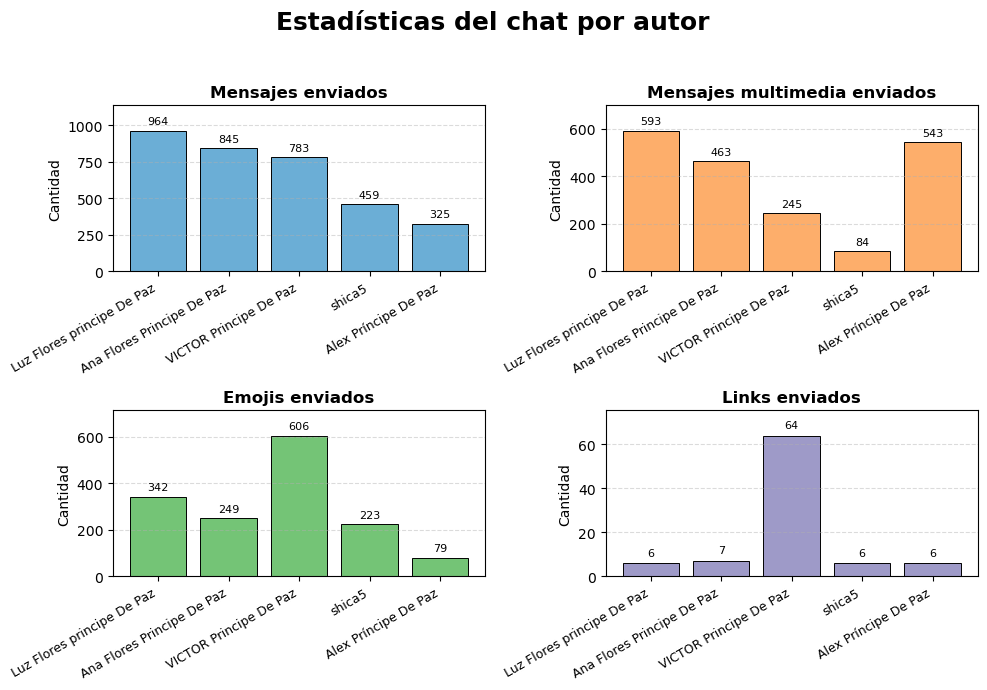

In [122]:
import numpy as np
import matplotlib.pyplot as plt

autores = stats_df["Autor"].tolist()
mensajes = stats_df["Mensajes"].to_numpy()
multimedia = stats_df["Mensajes_multimedia"].to_numpy()
emojis = stats_df["Emojis"].to_numpy()
links = stats_df["Links"].to_numpy()

x = np.arange(len(autores))

colores = {
    "mensajes": "#6BAED6",
    "multimedia": "#FDAE6B",
    "emojis": "#74C476",
    "links": "#9E9AC8"
}

fig, axs = plt.subplots(2, 2, figsize=(10, 7))
fig.suptitle("Estadísticas del chat por autor", fontsize=18, fontweight='bold')

def barras(ax, valores, titulo, color):
    ymax = valores.max() if len(valores) else 1
    ax.bar(x, valores, color=color, edgecolor='black', linewidth=0.7)
    ax.set_ylim(0, ymax * 1.18)  # <-- margen superior para que no se corten los números
    ax.set_title(titulo, fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(autores, rotation=30, ha='right', fontsize=9)
    ax.set_ylabel("Cantidad", fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.45)
    # Etiquetas numéricas con pequeño offset y sin recorte
    for xi, v in zip(x, valores):
        ax.text(xi, v + ymax * 0.03 + 0.5, f"{int(v)}",
                ha="center", va="bottom", fontsize=8, clip_on=False)

barras(axs[0, 0], mensajes,   "Mensajes enviados",             colores["mensajes"])
barras(axs[0, 1], multimedia, "Mensajes multimedia enviados",  colores["multimedia"])
barras(axs[1, 0], emojis,     "Emojis enviados",               colores["emojis"])
barras(axs[1, 1], links,      "Links enviados",                colores["links"])

plt.tight_layout(rect=[0, 0, 1, 0.95])
# Opcional al guardar: evita recortes en los bordes
# plt.savefig("estadisticas_chat.png", bbox_inches="tight", dpi=150)
plt.show()

Top palabras más usadas:
que: 747
de: 498
la: 405
el: 378
en: 298
ya: 248
es: 233
para: 198
si: 194
yo: 185
un: 184
dios: 182
los: 170
por: 164
con: 160
todos: 155
días: 153
buenos: 149
día: 139
chicos: 136


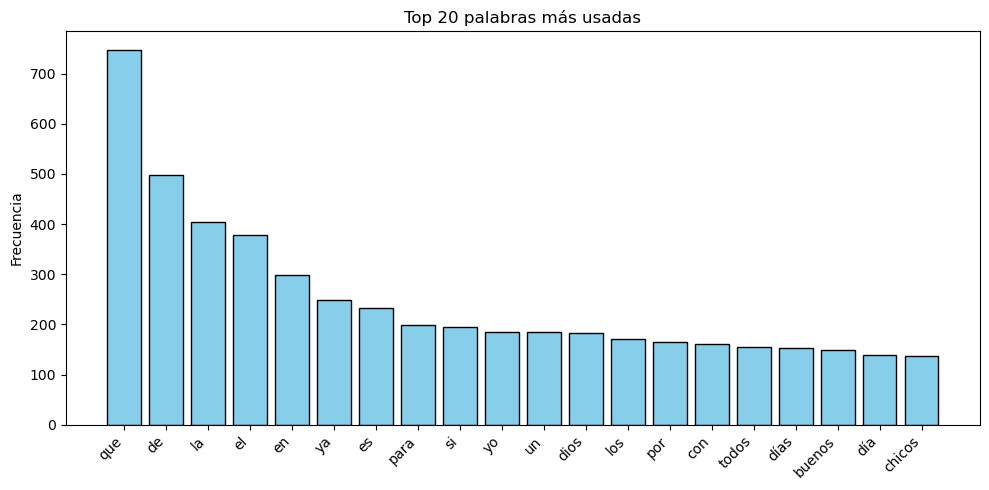

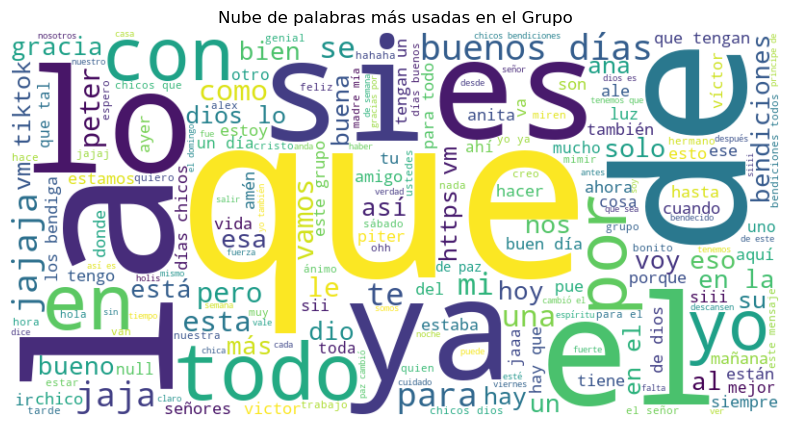

In [123]:
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re

# Unir todos los mensajes en un solo string
text = " ".join(messages_df["Message"])

# Lista de stopwords
stopwords = set(STOPWORDS)

# Quitar caracteres no alfabéticos y pasar a minúsculas
words = re.findall(r'\b\w+\b', text.lower())

# Filtrar stopwords y palabras vacías
filtered_words = [w for w in words if w not in stopwords and len(w) > 1]

# Contar palabras más frecuentes
word_counts = Counter(filtered_words)
top_n = 20  # número de palabras más frecuentes
top_words = word_counts.most_common(top_n)

# Mostrar en tabla
print("Top palabras más usadas:")
for palabra, freq in top_words:
    print(f"{palabra}: {freq}")

# Graficar top palabras
plt.figure(figsize=(10, 5))
plt.bar([w for w, _ in top_words], [c for _, c in top_words], color="skyblue", edgecolor="black")
plt.xticks(rotation=45, ha='right')
plt.title(f"Top {top_n} palabras más usadas")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# Generar nube de palabras
wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(" ".join(filtered_words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de palabras más usadas en el Grupo")
plt.show()


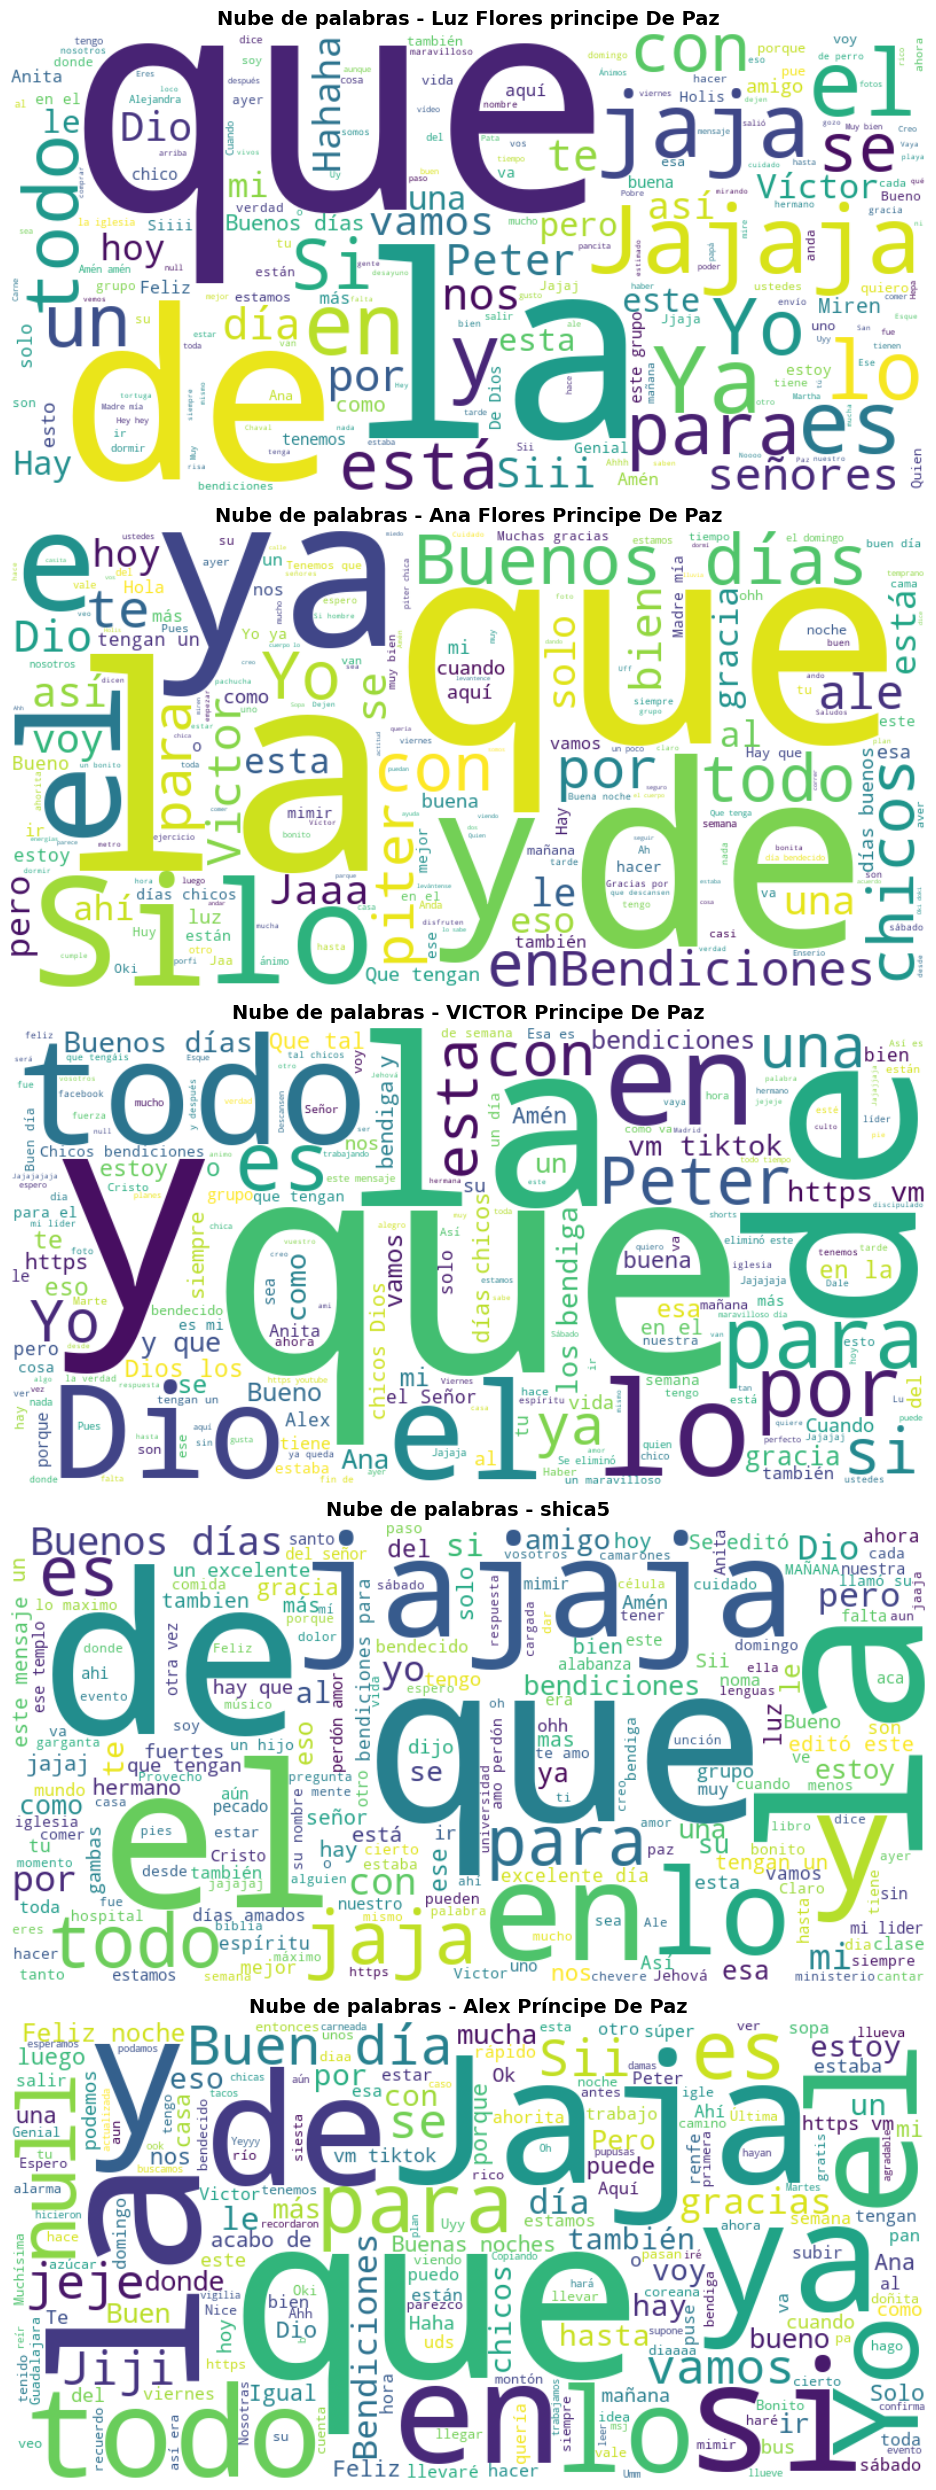

In [124]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)

# Filtramos solo autores reales
lista_autores = [a for a in df['Author'].unique() if pd.notna(a)]

# Crear figura con subplots dinámicos
fig, axs = plt.subplots(len(lista_autores), 1, figsize=(10, 5 * len(lista_autores)))

if len(lista_autores) == 1:
    axs = [axs]  # Para manejar caso de un solo autor

for ax, autor in zip(axs, lista_autores):
    # Unir todos los mensajes de este autor
    text = " ".join(messages_df[messages_df["Author"] == autor]["Message"])
    
    # Generar la nube
    wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(text)
    
    # Mostrar
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(f"Nube de palabras - {autor}", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()
